# Simulation test

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, Product

from scipy.sparse import csr_matrix

In [2]:
from data import load_narx_data, load_data

n_a, n_b = 2, 2
Split = [0.6, 0.2, 0.2] # split; [training, validation, test]
total_number_of_points = 3334 # total number of points to consider from the larger dataset (starting from index 0)

Xtrain,Ytrain = load_narx_data(n_a, n_b, total_number_of_points, section="train", split=Split, as_tensor=False)
Xval,Yval = load_narx_data(n_a, n_b, total_number_of_points, section="validation", split=Split, as_tensor=False)
Xtest,Ytest = load_data(section="test", split=Split, total_number_of_points=total_number_of_points, as_tensor=False)

Considering 10000 datapoints
Using 6000 datapoints for training set
Considering 10000 datapoints
Using 2000 datapoints for validation set
Considering 10000 datapoints
Using 2000 datapoints for test set


In [3]:
XtrainSparse = csr_matrix(Xtrain).toarray()
YtrainSparse = csr_matrix(Ytrain).toarray().transpose()

In [4]:
kernel = RBF() + WhiteKernel()
reg = GaussianProcessRegressor(kernel, n_restarts_optimizer=5)

reg.fit(XtrainSparse, YtrainSparse)

print(reg.kernel_)

RBF(length_scale=4.43) + WhiteKernel(noise_level=2.04e-05)


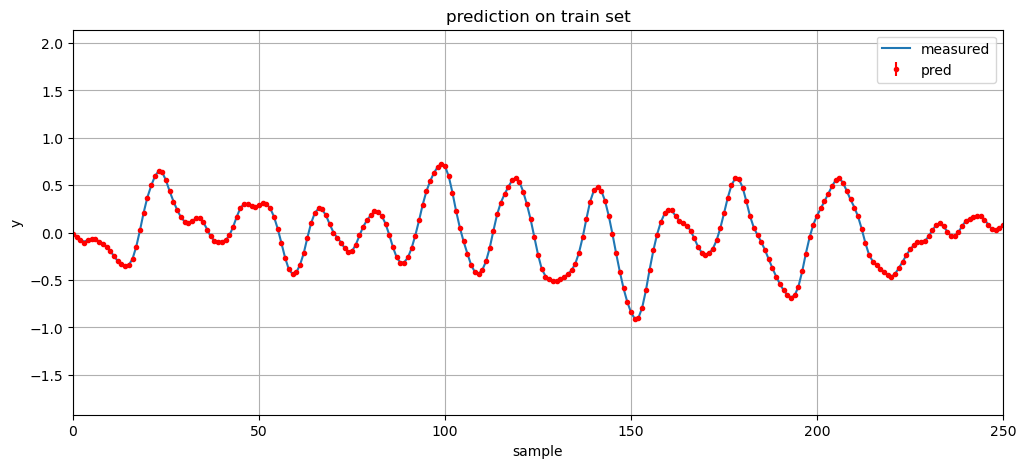

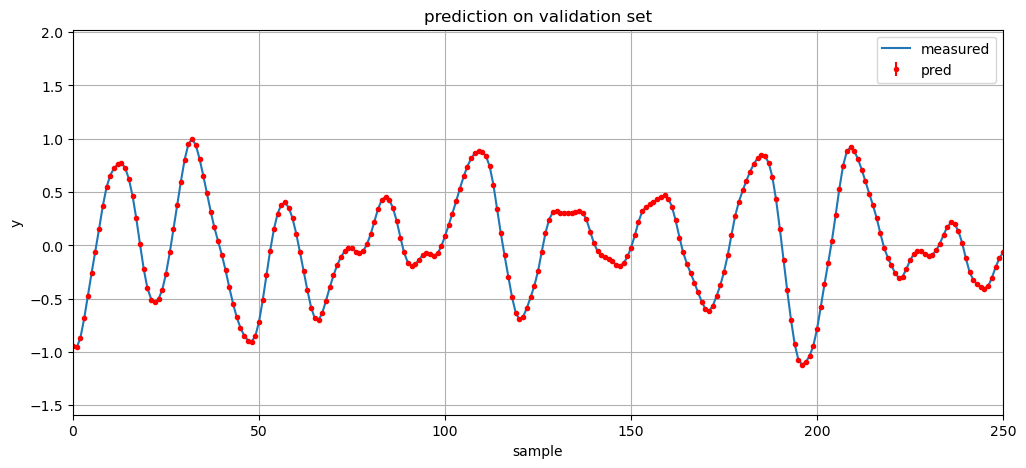

Validation NRMS= 0.011303895745402361


In [5]:
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True)
plt.figure(figsize=(12,5))
plt.plot(Ytrain)
plt.title('prediction on train set')
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True)
plt.errorbar(np.arange(len(Xtrain)), (Ytrain_pred), yerr=2*Ytrain_pred_std,fmt='.r')
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred'])
plt.xlim([0, 250])
plt.show() #a)

plt.figure(figsize=(12,5))
plt.title('prediction on validation set')
plt.plot(Yval)
Yval_pred, Yval_pred_std = reg.predict(Xval,return_std=True)
plt.errorbar(np.arange(len(Xval)), (Yval_pred), yerr=2*Yval_pred_std,fmt='.r')
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred'])
plt.xlim([0, 250])
plt.show()

print(f'Validation NRMS= {np.mean((Yval_pred-Yval)**2)**0.5/np.std(Yval)}')

In [6]:
def use_NARX_model_in_simulation(ulist, f, na, nb):
    #init upast and ypast as lists.
    upast = [0]*nb 
    ypast = [0]*na 
    
    ylist = []
    for unow in ulist:
        #compute the current y given by f
        ynow = f(upast,ypast) 
        
        #update past arrays
        upast.append(unow)
        upast.pop(0)
        ypast.append(ynow)
        ypast.pop(0)
        
        #save result
        ylist.append(ynow)
    return np.array(ylist) #return result

In [7]:
model_now = reg
fmodel = lambda u,y: model_now.predict(np.concatenate([u,y])[None,:])[0] 
ytest_sim = use_NARX_model_in_simulation(Xtest, fmodel, n_a, n_b)

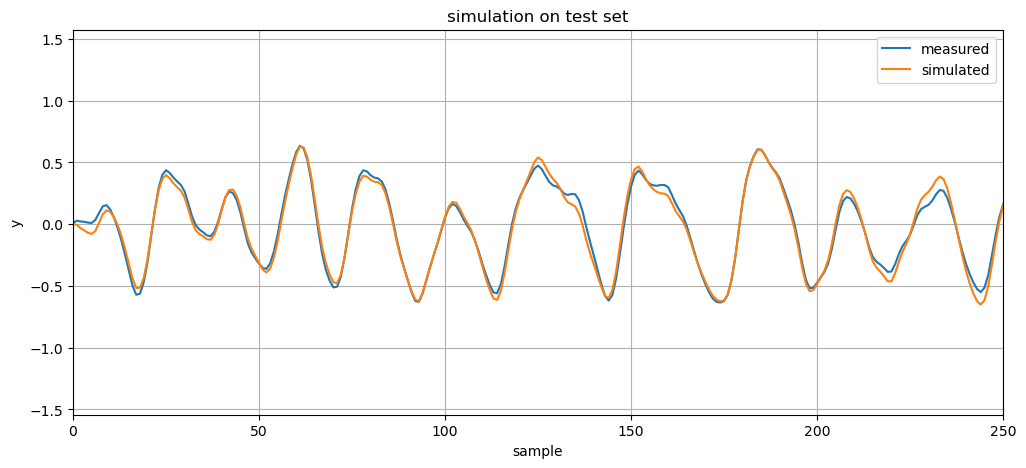

simulated test NRMS= 0.09165972843578661


In [8]:
plt.figure(figsize=(12,5))
plt.title('simulation on test set')
plt.plot(Ytest)
plt.plot(ytest_sim)
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','simulated'])
plt.xlim([0, 250])
plt.show()

print(f'simulated test NRMS= {np.mean((Ytest-ytest_sim)**2)**0.5/np.std(Ytest)}')

